# **Atividade 2 - Uso de Redes Neurais Profundas**

## **Disciplina:** CAP-421-3 Aprendizado Profundo

**Discintes:**

Gabriel Sansigolo

### **Importando bibliotecas**

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import DataLoader

### **Utiliza GPU (cuda), caso contrário, utiliza CPU**

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
cuda_id = torch.cuda.current_device()
torch.cuda.get_device_name(cuda_id)

'NVIDIA GeForce RTX 4080'

### **1 - Pré-processamento da Imagens**

In [4]:
path_dir = os.path.dirname("")

def load_images(path, pista = False):

    images = []
    filenames = os.listdir(path)
    
    for filename in tqdm(filenames):
        if filename == '_DS_Store':
            continue
        image = cv2.imread(os.path.join(path, filename))
        image = cv2.resize(image, dsize=(100,100))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        images.append(image)
        
        if pista == True:
            
            #apply gama 0.5
            invGamma = 1.0 / 0.5
            table = np.array([((i / 255.0) ** invGamma) * 255
            for i in np.arange(0, 256)]).astype("uint8")
            new_image = cv2.LUT(image, table)
                        
            images.append(new_image)



    return np.array(images)

### **2 - Dividindo os Dados (Treinamento e Teste)**

In [5]:
mapeado_train = load_images(os.path.join(path_dir,'Treinamento/Pistas/'), True)
nao_mapeado_train = load_images(os.path.join(path_dir,'Treinamento/NaoPistas/'), False)

nao_mapeado_train = nao_mapeado_train[:16140]

mapeado_test = load_images(os.path.join(path_dir,'Teste/NovasNaoPistas/'), False)
nao_mapeado_test = load_images(os.path.join(path_dir,'Teste/NovasPistas/'), False)

100%|██████████| 530/530 [00:01<00:00, 529.03it/s]


### **3 - Verificação das Dimensões dos Dados de Treinamento e Teste**

In [6]:
print(mapeado_train.shape)
print(nao_mapeado_train.shape)
print(mapeado_test.shape)
print(nao_mapeado_test.shape)

(6456, 100, 100, 3)
(16140, 100, 100, 3)
(1935, 100, 100, 3)
(530, 100, 100, 3)


In [7]:
X_train = np.append(mapeado_train, nao_mapeado_train, axis=0)
X_test  = np.append(mapeado_test, nao_mapeado_test, axis=0)

X_test = X_test[100:]
X_val = X_test[:100]

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(22596, 100, 100, 3)
(2365, 100, 100, 3)
(100, 100, 100, 3)


In [8]:
y_train = np.array([0] * len(mapeado_train) + [1] * len(nao_mapeado_train))
y_test = np.array([0] * len(mapeado_test) + [1] * len(nao_mapeado_test))

y_test = y_test[100:]
y_val = y_test[:100] 

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(22596,)
(2365,)
(100,)


In [9]:
y_train = torch.from_numpy(y_train.reshape(len(y_train),1))
y_test = torch.from_numpy(y_test.reshape(len(y_test),1))
y_val = torch.from_numpy(y_val.reshape(len(y_val),1))

### **4 - Execução de Transformações Necessárias para Dados de Treinamento e Teste**

In [10]:
transforms_train = transforms.Compose([transforms.ToTensor(), 
                                       transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) # squeeze to -1 and 1
                                      ])

In [11]:
transforms_test = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

In [12]:
transforms_val = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

### **5 - Definição das Classes**

In [13]:
class Mapeado_Nao_Mapeado():
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        
        if self.transform:
            image = self.transform(image)
        
        return (image, label)

### **6 - Criação dos DataLoaders para os Dados de Treinamento e Teste**

In [14]:
train_dataset = Mapeado_Nao_Mapeado(images=X_train, labels=y_train, transform=transforms_train)
test_dataset  = Mapeado_Nao_Mapeado(images=X_test, labels=y_test, transform=transforms_test)
val_dataset  = Mapeado_Nao_Mapeado(images=X_val, labels=y_val, transform=transforms_val)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader  = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)

In [16]:
iterator = iter(train_loader)
image_batch, label_batch = next(iterator)

print(image_batch.shape)

torch.Size([32, 3, 100, 100])


In [17]:
image_batch_permuted = image_batch.permute(0, 2, 3, 1)

print(image_batch_permuted.shape)

torch.Size([32, 100, 100, 3])


### **7 - Definindo a Rede Neural Convolucional (CNN) para Classificação**

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn0 = nn.BatchNorm2d(num_features=16)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        # self.maxpool
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        # self.maxpool
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        # self.maxpool
        
        self.dropout = nn.Dropout(p=0.5)
        self.fc0 = nn.Linear(in_features=128*6*6, out_features=64)
        self.fc1 = nn.Linear(in_features=64, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=1)
        
    def forward(self, x):
        x = F.relu(self.bn0(self.conv0(x)))
        x = self.maxpool(x)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = x.reshape(x.shape[0], -1)
        
        x = self.dropout(x)
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        
        return x

In [19]:
model = CNN().to(device)

In [20]:
summary(model, input_size=(4,3,100,100))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [4, 1]                    --
├─Conv2d: 1-1                            [4, 16, 100, 100]         432
├─BatchNorm2d: 1-2                       [4, 16, 100, 100]         32
├─MaxPool2d: 1-3                         [4, 16, 50, 50]           --
├─Conv2d: 1-4                            [4, 32, 50, 50]           4,608
├─BatchNorm2d: 1-5                       [4, 32, 50, 50]           64
├─MaxPool2d: 1-6                         [4, 32, 25, 25]           --
├─Conv2d: 1-7                            [4, 64, 25, 25]           18,432
├─BatchNorm2d: 1-8                       [4, 64, 25, 25]           128
├─MaxPool2d: 1-9                         [4, 64, 12, 12]           --
├─Conv2d: 1-10                           [4, 128, 12, 12]          73,728
├─BatchNorm2d: 1-11                      [4, 128, 12, 12]          256
├─MaxPool2d: 1-12                        [4, 128, 6, 6]            --
├

### **8 - Definição da Função de Perda e do Otimizador**

In [21]:
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### **9 - Definição da Função de Predição de Dados de Teste**

In [22]:
def predict_test_data(model, test_loader):
    
    num_correct = 0
    num_samples = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.float().to(device)
            y_test = y_test.float().to(device)

            test_preds = model(X_test)
            test_loss  = loss_function(test_preds, y_test)
            
            rounded_test_preds = torch.round(test_preds)
            num_correct += torch.sum(rounded_test_preds == y_test)
            num_samples += len(y_test)
        
    model.train()
    
    test_acc = num_correct/num_samples
    
    return test_loss, test_acc

### **10 - Treinamento do Modelo CNN e Avaliação do Desempenho**

In [23]:
train_losses = []    
train_accs = []
test_losses = []
test_accs  = []

for epoch in range(100):
    
    num_correct_train = 0
    num_samples_train = 0
    for batch, (X_train, y_train) in tqdm(enumerate(train_loader), total=len(train_loader)):
        X_train = X_train.float().to(device)
        y_train = y_train.float().to(device)
        
        train_preds = model(X_train)
        train_loss = loss_function(train_preds, y_train)
        
        with torch.no_grad():
            rounded_train_preds = torch.round(train_preds)
            num_correct_train += torch.sum(rounded_train_preds == y_train)
            num_samples_train += len(y_train)
            
        optimizer.zero_grad()
        train_loss.backward()
        
        optimizer.step()
    
    train_acc = num_correct_train/num_samples_train
    test_loss, test_acc = predict_test_data(model, test_loader)
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    train_accs.append(train_acc.item())
    test_accs.append(test_acc.item())
        
    print(f'Epoch: {epoch} \t|' \
            f' Train loss: {np.round(train_loss.item(),3)} \t|' \
            f' Test loss: {np.round(test_loss.item(),3)} \t|' \
            f' Train acc: {np.round(train_acc.item(),2)} \t|' \
            f' Test acc: {np.round(test_acc.item(),2)}')

100%|██████████| 706/706 [00:05<00:00, 130.30it/s]


Epoch: 0 	| Train loss: 0.605 	| Test loss: 2.22 	| Train acc: 0.85 	| Test acc: 0.22


100%|██████████| 706/706 [00:05<00:00, 135.12it/s]


Epoch: 1 	| Train loss: 0.359 	| Test loss: 1.859 	| Train acc: 0.85 	| Test acc: 0.22


100%|██████████| 706/706 [00:05<00:00, 135.83it/s]


Epoch: 2 	| Train loss: 0.235 	| Test loss: 1.918 	| Train acc: 0.86 	| Test acc: 0.25


100%|██████████| 706/706 [00:05<00:00, 135.94it/s]


Epoch: 3 	| Train loss: 0.359 	| Test loss: 2.055 	| Train acc: 0.86 	| Test acc: 0.22


100%|██████████| 706/706 [00:05<00:00, 135.93it/s]


Epoch: 4 	| Train loss: 0.486 	| Test loss: 2.21 	| Train acc: 0.86 	| Test acc: 0.21


100%|██████████| 706/706 [00:05<00:00, 137.40it/s]


Epoch: 5 	| Train loss: 0.265 	| Test loss: 2.831 	| Train acc: 0.86 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 133.10it/s]


Epoch: 6 	| Train loss: 0.34 	| Test loss: 1.908 	| Train acc: 0.86 	| Test acc: 0.22


100%|██████████| 706/706 [00:05<00:00, 137.18it/s]


Epoch: 7 	| Train loss: 0.46 	| Test loss: 2.148 	| Train acc: 0.87 	| Test acc: 0.18


100%|██████████| 706/706 [00:05<00:00, 136.46it/s]


Epoch: 8 	| Train loss: 0.482 	| Test loss: 2.009 	| Train acc: 0.87 	| Test acc: 0.18


100%|██████████| 706/706 [00:05<00:00, 136.70it/s]


Epoch: 9 	| Train loss: 0.322 	| Test loss: 2.299 	| Train acc: 0.87 	| Test acc: 0.19


100%|██████████| 706/706 [00:05<00:00, 137.13it/s]


Epoch: 10 	| Train loss: 0.375 	| Test loss: 2.986 	| Train acc: 0.87 	| Test acc: 0.21


100%|██████████| 706/706 [00:05<00:00, 140.23it/s]


Epoch: 11 	| Train loss: 0.21 	| Test loss: 2.371 	| Train acc: 0.87 	| Test acc: 0.21


100%|██████████| 706/706 [00:05<00:00, 137.45it/s]


Epoch: 12 	| Train loss: 0.355 	| Test loss: 1.981 	| Train acc: 0.88 	| Test acc: 0.21


100%|██████████| 706/706 [00:05<00:00, 137.87it/s]


Epoch: 13 	| Train loss: 0.256 	| Test loss: 2.247 	| Train acc: 0.88 	| Test acc: 0.26


100%|██████████| 706/706 [00:05<00:00, 138.58it/s]


Epoch: 14 	| Train loss: 0.305 	| Test loss: 2.259 	| Train acc: 0.88 	| Test acc: 0.21


100%|██████████| 706/706 [00:05<00:00, 136.28it/s]


Epoch: 15 	| Train loss: 0.194 	| Test loss: 2.58 	| Train acc: 0.88 	| Test acc: 0.25


100%|██████████| 706/706 [00:05<00:00, 138.28it/s]


Epoch: 16 	| Train loss: 0.218 	| Test loss: 2.462 	| Train acc: 0.88 	| Test acc: 0.21


100%|██████████| 706/706 [00:05<00:00, 135.53it/s]


Epoch: 17 	| Train loss: 0.291 	| Test loss: 3.006 	| Train acc: 0.88 	| Test acc: 0.21


100%|██████████| 706/706 [00:05<00:00, 138.06it/s]


Epoch: 18 	| Train loss: 0.262 	| Test loss: 2.399 	| Train acc: 0.89 	| Test acc: 0.21


100%|██████████| 706/706 [00:05<00:00, 135.37it/s]


Epoch: 19 	| Train loss: 0.303 	| Test loss: 3.129 	| Train acc: 0.89 	| Test acc: 0.19


100%|██████████| 706/706 [00:04<00:00, 141.71it/s]


Epoch: 20 	| Train loss: 0.277 	| Test loss: 2.783 	| Train acc: 0.89 	| Test acc: 0.21


100%|██████████| 706/706 [00:05<00:00, 139.53it/s]


Epoch: 21 	| Train loss: 0.121 	| Test loss: 3.155 	| Train acc: 0.89 	| Test acc: 0.21


100%|██████████| 706/706 [00:05<00:00, 138.67it/s]


Epoch: 22 	| Train loss: 0.238 	| Test loss: 2.86 	| Train acc: 0.89 	| Test acc: 0.21


100%|██████████| 706/706 [00:05<00:00, 139.83it/s]


Epoch: 23 	| Train loss: 0.287 	| Test loss: 3.333 	| Train acc: 0.9 	| Test acc: 0.21


100%|██████████| 706/706 [00:04<00:00, 144.41it/s]


Epoch: 24 	| Train loss: 0.159 	| Test loss: 3.487 	| Train acc: 0.9 	| Test acc: 0.22


100%|██████████| 706/706 [00:04<00:00, 142.64it/s]


Epoch: 25 	| Train loss: 0.303 	| Test loss: 3.12 	| Train acc: 0.91 	| Test acc: 0.21


100%|██████████| 706/706 [00:05<00:00, 140.47it/s]


Epoch: 26 	| Train loss: 0.114 	| Test loss: 3.382 	| Train acc: 0.91 	| Test acc: 0.21


100%|██████████| 706/706 [00:04<00:00, 144.90it/s]


Epoch: 27 	| Train loss: 0.132 	| Test loss: 2.533 	| Train acc: 0.91 	| Test acc: 0.2


100%|██████████| 706/706 [00:04<00:00, 141.72it/s]


Epoch: 28 	| Train loss: 0.109 	| Test loss: 3.749 	| Train acc: 0.91 	| Test acc: 0.21


100%|██████████| 706/706 [00:05<00:00, 140.92it/s]


Epoch: 29 	| Train loss: 0.278 	| Test loss: 4.387 	| Train acc: 0.92 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 136.92it/s]


Epoch: 30 	| Train loss: 0.117 	| Test loss: 3.476 	| Train acc: 0.92 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 138.22it/s]


Epoch: 31 	| Train loss: 0.123 	| Test loss: 2.486 	| Train acc: 0.92 	| Test acc: 0.21


100%|██████████| 706/706 [00:05<00:00, 136.06it/s]


Epoch: 32 	| Train loss: 0.206 	| Test loss: 3.94 	| Train acc: 0.92 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 138.06it/s]


Epoch: 33 	| Train loss: 0.214 	| Test loss: 3.699 	| Train acc: 0.93 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 136.89it/s]


Epoch: 34 	| Train loss: 0.251 	| Test loss: 8.208 	| Train acc: 0.93 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 136.19it/s]


Epoch: 35 	| Train loss: 0.127 	| Test loss: 4.715 	| Train acc: 0.93 	| Test acc: 0.21


100%|██████████| 706/706 [00:05<00:00, 140.55it/s]


Epoch: 36 	| Train loss: 0.145 	| Test loss: 3.971 	| Train acc: 0.93 	| Test acc: 0.2


100%|██████████| 706/706 [00:04<00:00, 141.59it/s]


Epoch: 37 	| Train loss: 0.124 	| Test loss: 5.376 	| Train acc: 0.94 	| Test acc: 0.2


100%|██████████| 706/706 [00:04<00:00, 142.94it/s]


Epoch: 38 	| Train loss: 0.224 	| Test loss: 5.223 	| Train acc: 0.94 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 137.66it/s]


Epoch: 39 	| Train loss: 0.191 	| Test loss: 4.913 	| Train acc: 0.94 	| Test acc: 0.19


100%|██████████| 706/706 [00:04<00:00, 142.46it/s]


Epoch: 40 	| Train loss: 0.065 	| Test loss: 4.118 	| Train acc: 0.94 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 134.85it/s]


Epoch: 41 	| Train loss: 0.205 	| Test loss: 5.85 	| Train acc: 0.94 	| Test acc: 0.2


100%|██████████| 706/706 [00:06<00:00, 109.80it/s]


Epoch: 42 	| Train loss: 0.281 	| Test loss: 6.072 	| Train acc: 0.95 	| Test acc: 0.2


100%|██████████| 706/706 [00:11<00:00, 60.66it/s]


Epoch: 43 	| Train loss: 0.189 	| Test loss: 4.187 	| Train acc: 0.95 	| Test acc: 0.21


100%|██████████| 706/706 [00:11<00:00, 61.16it/s]


Epoch: 44 	| Train loss: 0.013 	| Test loss: 6.402 	| Train acc: 0.95 	| Test acc: 0.2


100%|██████████| 706/706 [00:11<00:00, 61.01it/s]


Epoch: 45 	| Train loss: 0.354 	| Test loss: 6.1 	| Train acc: 0.96 	| Test acc: 0.2


100%|██████████| 706/706 [00:07<00:00, 92.72it/s] 


Epoch: 46 	| Train loss: 0.031 	| Test loss: 9.052 	| Train acc: 0.96 	| Test acc: 0.19


100%|██████████| 706/706 [00:05<00:00, 123.40it/s]


Epoch: 47 	| Train loss: 0.065 	| Test loss: 5.107 	| Train acc: 0.96 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 130.43it/s]


Epoch: 48 	| Train loss: 0.077 	| Test loss: 11.651 	| Train acc: 0.96 	| Test acc: 0.21


100%|██████████| 706/706 [00:05<00:00, 134.42it/s]


Epoch: 49 	| Train loss: 0.206 	| Test loss: 5.338 	| Train acc: 0.96 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 136.12it/s]


Epoch: 50 	| Train loss: 0.033 	| Test loss: 8.613 	| Train acc: 0.96 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 133.45it/s]


Epoch: 51 	| Train loss: 0.139 	| Test loss: 9.03 	| Train acc: 0.96 	| Test acc: 0.21


100%|██████████| 706/706 [00:05<00:00, 138.67it/s]


Epoch: 52 	| Train loss: 0.071 	| Test loss: 5.33 	| Train acc: 0.97 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 137.28it/s]


Epoch: 53 	| Train loss: 0.035 	| Test loss: 10.377 	| Train acc: 0.97 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 139.06it/s]


Epoch: 54 	| Train loss: 0.054 	| Test loss: 5.443 	| Train acc: 0.97 	| Test acc: 0.21


100%|██████████| 706/706 [00:05<00:00, 136.72it/s]


Epoch: 55 	| Train loss: 0.093 	| Test loss: 5.543 	| Train acc: 0.97 	| Test acc: 0.22


100%|██████████| 706/706 [00:05<00:00, 129.76it/s]


Epoch: 56 	| Train loss: 0.108 	| Test loss: 6.856 	| Train acc: 0.97 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 126.66it/s]


Epoch: 57 	| Train loss: 0.148 	| Test loss: 8.52 	| Train acc: 0.97 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 129.51it/s]


Epoch: 58 	| Train loss: 0.043 	| Test loss: 13.962 	| Train acc: 0.97 	| Test acc: 0.19


100%|██████████| 706/706 [00:05<00:00, 122.90it/s]


Epoch: 59 	| Train loss: 0.023 	| Test loss: 8.573 	| Train acc: 0.97 	| Test acc: 0.21


100%|██████████| 706/706 [00:05<00:00, 132.80it/s]


Epoch: 60 	| Train loss: 0.027 	| Test loss: 12.199 	| Train acc: 0.97 	| Test acc: 0.21


100%|██████████| 706/706 [00:05<00:00, 139.64it/s]


Epoch: 61 	| Train loss: 0.067 	| Test loss: 13.52 	| Train acc: 0.97 	| Test acc: 0.19


100%|██████████| 706/706 [00:05<00:00, 136.57it/s]


Epoch: 62 	| Train loss: 0.024 	| Test loss: 11.297 	| Train acc: 0.97 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 137.99it/s]


Epoch: 63 	| Train loss: 0.051 	| Test loss: 11.443 	| Train acc: 0.97 	| Test acc: 0.19


100%|██████████| 706/706 [00:05<00:00, 135.77it/s]


Epoch: 64 	| Train loss: 0.018 	| Test loss: 8.427 	| Train acc: 0.98 	| Test acc: 0.19


100%|██████████| 706/706 [00:05<00:00, 140.44it/s]


Epoch: 65 	| Train loss: 0.073 	| Test loss: 12.677 	| Train acc: 0.98 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 137.30it/s]


Epoch: 66 	| Train loss: 0.07 	| Test loss: 13.214 	| Train acc: 0.98 	| Test acc: 0.19


100%|██████████| 706/706 [00:05<00:00, 130.18it/s]


Epoch: 67 	| Train loss: 0.006 	| Test loss: 25.297 	| Train acc: 0.98 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 135.29it/s]


Epoch: 68 	| Train loss: 0.067 	| Test loss: 13.874 	| Train acc: 0.98 	| Test acc: 0.19


100%|██████████| 706/706 [00:05<00:00, 122.75it/s]


Epoch: 69 	| Train loss: 0.04 	| Test loss: 12.945 	| Train acc: 0.98 	| Test acc: 0.19


100%|██████████| 706/706 [00:05<00:00, 132.70it/s]


Epoch: 70 	| Train loss: 0.054 	| Test loss: 7.181 	| Train acc: 0.98 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 132.79it/s]


Epoch: 71 	| Train loss: 0.13 	| Test loss: 7.766 	| Train acc: 0.98 	| Test acc: 0.22


100%|██████████| 706/706 [00:05<00:00, 127.92it/s]


Epoch: 72 	| Train loss: 0.186 	| Test loss: 12.498 	| Train acc: 0.98 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 133.52it/s]


Epoch: 73 	| Train loss: 0.027 	| Test loss: 7.992 	| Train acc: 0.98 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 131.75it/s]


Epoch: 74 	| Train loss: 0.005 	| Test loss: 15.769 	| Train acc: 0.98 	| Test acc: 0.19


100%|██████████| 706/706 [00:05<00:00, 128.55it/s]


Epoch: 75 	| Train loss: 0.094 	| Test loss: 12.649 	| Train acc: 0.98 	| Test acc: 0.18


100%|██████████| 706/706 [00:05<00:00, 121.93it/s]


Epoch: 76 	| Train loss: 0.083 	| Test loss: 9.69 	| Train acc: 0.98 	| Test acc: 0.2


100%|██████████| 706/706 [00:10<00:00, 67.05it/s] 


Epoch: 77 	| Train loss: 0.033 	| Test loss: 5.808 	| Train acc: 0.98 	| Test acc: 0.2


100%|██████████| 706/706 [00:11<00:00, 60.51it/s]


Epoch: 78 	| Train loss: 0.019 	| Test loss: 10.048 	| Train acc: 0.98 	| Test acc: 0.22


100%|██████████| 706/706 [00:06<00:00, 112.68it/s]


Epoch: 79 	| Train loss: 0.079 	| Test loss: 15.474 	| Train acc: 0.98 	| Test acc: 0.19


100%|██████████| 706/706 [00:05<00:00, 135.92it/s]


Epoch: 80 	| Train loss: 0.133 	| Test loss: 19.062 	| Train acc: 0.98 	| Test acc: 0.2


100%|██████████| 706/706 [00:05<00:00, 126.22it/s]


Epoch: 81 	| Train loss: 0.09 	| Test loss: 5.277 	| Train acc: 0.98 	| Test acc: 0.22


100%|██████████| 706/706 [00:11<00:00, 63.36it/s]


Epoch: 82 	| Train loss: 0.028 	| Test loss: 4.403 	| Train acc: 0.98 	| Test acc: 0.2


100%|██████████| 706/706 [00:11<00:00, 61.23it/s]


Epoch: 83 	| Train loss: 0.012 	| Test loss: 5.895 	| Train acc: 0.98 	| Test acc: 0.2


100%|██████████| 706/706 [00:11<00:00, 60.24it/s]


Epoch: 84 	| Train loss: 0.009 	| Test loss: 20.094 	| Train acc: 0.98 	| Test acc: 0.19


100%|██████████| 706/706 [00:11<00:00, 59.85it/s]


Epoch: 85 	| Train loss: 0.049 	| Test loss: 10.891 	| Train acc: 0.98 	| Test acc: 0.2


100%|██████████| 706/706 [00:11<00:00, 59.98it/s]


Epoch: 86 	| Train loss: 0.002 	| Test loss: 18.51 	| Train acc: 0.98 	| Test acc: 0.18


100%|██████████| 706/706 [00:11<00:00, 62.07it/s]


Epoch: 87 	| Train loss: 0.019 	| Test loss: 9.245 	| Train acc: 0.98 	| Test acc: 0.2


100%|██████████| 706/706 [00:11<00:00, 60.42it/s]


Epoch: 88 	| Train loss: 0.022 	| Test loss: 18.334 	| Train acc: 0.98 	| Test acc: 0.19


100%|██████████| 706/706 [00:11<00:00, 60.58it/s]


Epoch: 89 	| Train loss: 0.047 	| Test loss: 12.551 	| Train acc: 0.98 	| Test acc: 0.2


100%|██████████| 706/706 [00:11<00:00, 60.69it/s]


Epoch: 90 	| Train loss: 0.013 	| Test loss: 5.499 	| Train acc: 0.98 	| Test acc: 0.2


100%|██████████| 706/706 [00:11<00:00, 61.73it/s]


Epoch: 91 	| Train loss: 0.006 	| Test loss: 17.048 	| Train acc: 0.98 	| Test acc: 0.18


100%|██████████| 706/706 [00:11<00:00, 60.43it/s]


Epoch: 92 	| Train loss: 0.012 	| Test loss: 18.638 	| Train acc: 0.98 	| Test acc: 0.2


100%|██████████| 706/706 [00:11<00:00, 60.61it/s]


Epoch: 93 	| Train loss: 0.038 	| Test loss: 16.815 	| Train acc: 0.99 	| Test acc: 0.19


100%|██████████| 706/706 [00:11<00:00, 61.22it/s]


Epoch: 94 	| Train loss: 0.189 	| Test loss: 10.312 	| Train acc: 0.98 	| Test acc: 0.2


100%|██████████| 706/706 [00:11<00:00, 59.55it/s]


Epoch: 95 	| Train loss: 0.01 	| Test loss: 6.886 	| Train acc: 0.99 	| Test acc: 0.2


100%|██████████| 706/706 [00:11<00:00, 60.39it/s]


Epoch: 96 	| Train loss: 0.014 	| Test loss: 25.587 	| Train acc: 0.99 	| Test acc: 0.19


100%|██████████| 706/706 [00:11<00:00, 61.43it/s]


Epoch: 97 	| Train loss: 0.076 	| Test loss: 14.665 	| Train acc: 0.99 	| Test acc: 0.2


100%|██████████| 706/706 [00:11<00:00, 60.36it/s]


Epoch: 98 	| Train loss: 0.178 	| Test loss: 24.483 	| Train acc: 0.99 	| Test acc: 0.19


100%|██████████| 706/706 [00:11<00:00, 59.45it/s]


Epoch: 99 	| Train loss: 0.06 	| Test loss: 6.555 	| Train acc: 0.99 	| Test acc: 0.2


### **11 - Visualização das Curvas de Treinamento e Teste**

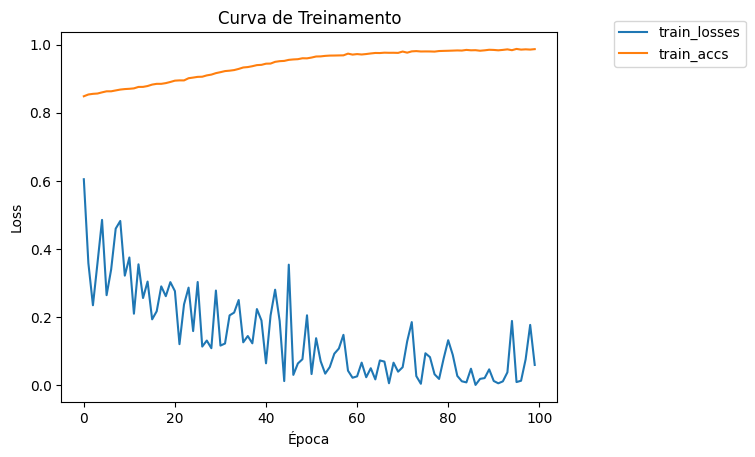

In [24]:
plt.plot(range(100), train_losses , label='train_losses')
plt.plot(range(100), train_accs, label='train_accs')
plt.title('Curva de Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')   
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

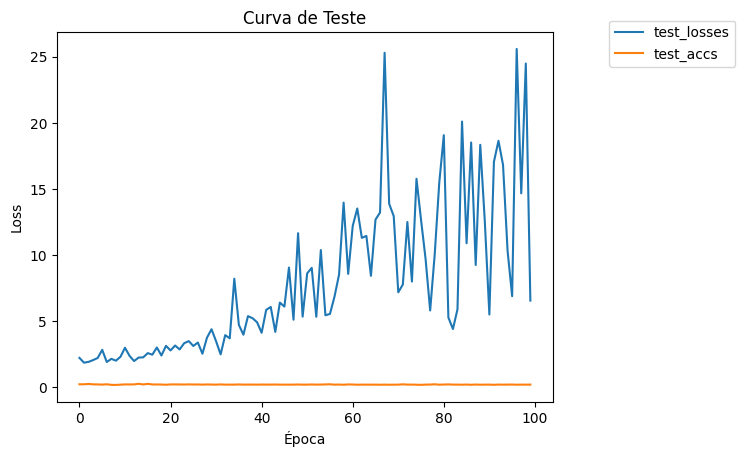

In [25]:
plt.plot(range(100), test_losses , label='test_losses')
plt.plot(range(100), test_accs, label='test_accs')
plt.title('Curva de Teste')
plt.xlabel('Época')
plt.ylabel('Loss')  
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

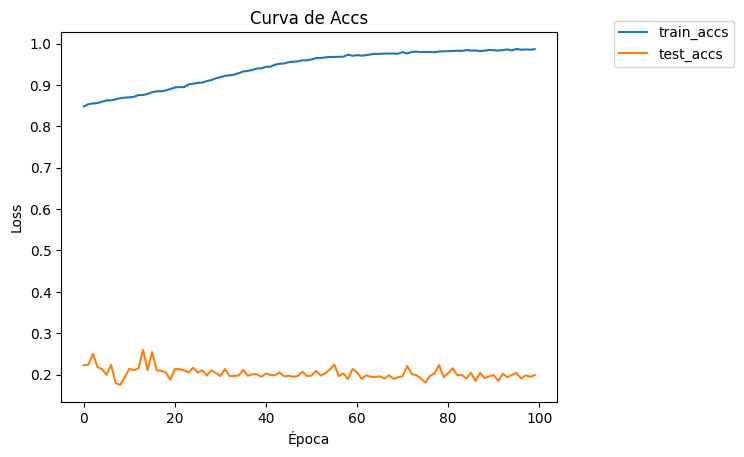

In [26]:
plt.plot(range(100), train_accs, label='train_accs')
plt.plot(range(100), test_accs, label='test_accs')
plt.title('Curva de Accs')
plt.xlabel('Época')
plt.ylabel('Loss')  
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

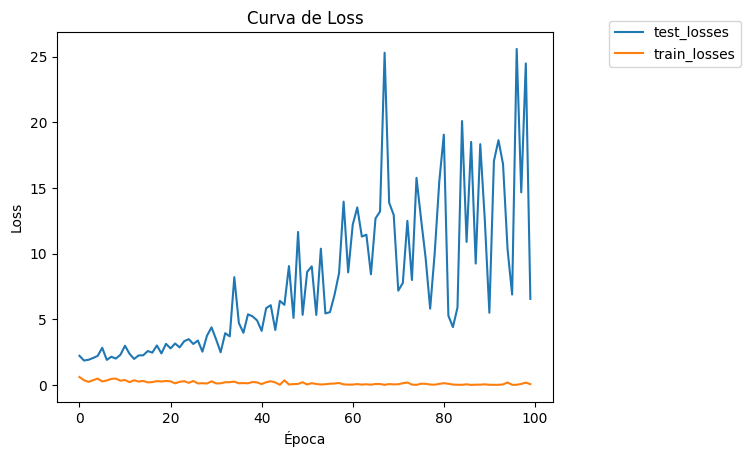

In [27]:
plt.plot(range(100), test_losses , label='test_losses')
plt.plot(range(100), train_losses , label='train_losses')
plt.title('Curva de Loss')
plt.xlabel('Época')
plt.ylabel('Loss')   
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

### **11.5 - Aplicação do Modelo nos Dados Validados para Score**

In [28]:
with torch.no_grad():
    listas = []
    for batch, (X_val, y_val) in tqdm(enumerate(val_loader), total=len(val_loader)):
        num_correct_train = 0
        num_samples_train = 0
        X_val = X_val.float().to(device)
        y_val = y_val.float().to(device)
        val_preds = model(X_val)
        rounded_validation_preds = torch.round(val_preds)
        num_correct_train += torch.sum(rounded_validation_preds == y_train)
        num_samples_train += len(y_train)

    acc = num_correct_train/num_samples_train

acc = acc.item()*100
print(str(acc) + '%')


100%|██████████| 3/3 [00:00<00:00, 74.72it/s]

71.875%


### **12 - Aplicação do Modelo nos Dados Não Validados**

In [29]:
todos = load_images(os.path.join(path_dir,'Todas/'), False)

100%|██████████| 44033/44033 [02:56<00:00, 249.67it/s]


In [30]:
print(todos.shape)

(44033, 100, 100, 3)


In [31]:
class Validacao():
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        
        if self.transform:
            image = self.transform(image)
        
        return (image)

In [32]:
transforms_todos = transforms.Compose([transforms.ToTensor(), 
                                       transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) # squeeze to -1 and 1
                                      ])

In [33]:
todos_dataset  = Validacao(images=todos, transform=transforms_todos)

In [34]:
todos_loader  = DataLoader(todos_dataset, batch_size=32, shuffle=True, drop_last=True)

In [39]:
with torch.no_grad():

    n_pista = 0
    n_nao_pista = 0
    listas = []

    for batch, (val_todo) in enumerate(todos_loader):
        val_todo = val_todo.to(device)
        validation_preds = model(val_todo)
        rounded_validation_preds = torch.round(validation_preds)
        list = [int(a[0]) for a in rounded_validation_preds]
        listas.append(list)
        n_nao_pista += list.count(1) 
        n_pista += list.count(0) 

In [40]:
for lista in listas[:10]:
    print(lista)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0]
[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0]
[0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [41]:
n_pista

6082

In [42]:
n_nao_pista

37950